In [ ]:
import numpy as np
import pandas as pd
import random
from  scipy.stats import bernoulli
import matplotlib.pyplot as plt
import time

# Implementing a simple GA algorithm for the Travelling Salesman Problem

In [ ]:
def sampleSolution(cities):
  
    """
      Samples randomly a route, represented as a permutation of the cities
    """
    route = random.sample(cities, len(cities))
    return route

In [ ]:
def map_index_to_city(cities):
    """
      From a list of cities, returns a dictionary with 
      key = length of the city in the dictionary
      value = coordinates of the city
    """
    dictionary_cities = {}
    for _ in range(len(cities)):
      dictionary_cities[_+1] = cities[_]
    return dictionary_cities

In [ ]:
def distance(city1, city2):

    """
      Computes the distance between the cities 
    """

    x_1 = city1[0]
    y_1 = city1[1]
    x_2 = city2[0]
    y_2 = city2[1]
    distance = np.sqrt((x_1-x_2)**2+(y_1-y_2)**2)
    #print(distance)
    return distance

In [ ]:
def fitness_and_distance(representation, dist_Matrix):
  """
    Computes the distance and the fitness of a candidate (route) as the inverse of the 
    total distance travelled
    Parameters
        ----------
        representation : list of integers
        dist_Matrix : np.array 
            its [i,j] element is the distance between city i and city j
  """

  # first, we compute the distance among the cities in the route
  distance_route = 0
  for _ in range(len(representation)-1):
    #distance_route += distance(route[_], route[_+1])
    distance_route +=dist_Matrix[int(representation[_]), int(representation[_+1])]
  # the fitness is defined as the inverse of the distance
  fitness = 1/distance_route

  return fitness, distance_route

In [ ]:
def computeFitnessForGeneration(generation, N_Pool, dicCities, dist_Matrix):
  """
    Applies the fitness function to every route in the generation
    Parameters
        ----------
        generation : list of representations
        N_Pool : number of routes in the generation
        dicCities : dictionary containing cities coordinates
        dist_Matrix : np.array 
            its [i,j] element is the distance between city i and city j
  """
  fit_values = []
  distance_values = []
  for i in range(N_Pool):
    candidate = generation[i]
    #route = get_route_from_representation(candidate, dicCities)
    fit_route, dis_route = fitness_and_distance(candidate,  dist_Matrix)
    fit_values.append(fit_route)
    distance_values.append(dis_route)
  return distance_values, fit_values

In [ ]:
def selectFittest(pool, fitnessPool):
    """
      Implements tournament selection with K = 2
      Parameters
        ----------
        pool : list of representations
        fitnessPool : np.array
            contains the fitness value of the representation in the pool
    """
    # This implementation of the K-tournament returns the list of parents
    # Selected one-by-one choosing randomly two routes and then appending the fittest
    # between these two, until we obtain a new pool with the same length of
    # the original one
    parents = []
    N_Pool = len(pool)
    for _ in range(len(pool)):
      id1 = random.randint(0,N_Pool -1)
      id2 = random.randint(0,N_Pool -1)
      if fitnessPool[id1]> fitnessPool[id2]:
        best = id1
      else:
        best = id2
      parents.append(pool[best])
    return parents
      
             
    

In [ ]:
def replace_complementary(parent, child, startGene, endGene):
   """
    Given a parent and the child with positions filled in from startGene and endGene,
    computes the missing parts of the child
   """
   replace_left = 0
   replace_right = 0
   swaps_right = (len(parent) - 1 - endGene)
   swaps_left = startGene
   
   # replacing missing parts from the right
   for i in range(len(parent)):
      if replace_right == swaps_right:
        break
      if int(parent[i]) not in child:
          replace_right += 1   
          child[endGene  + replace_right] = int(parent[i])
           
  # replacing missing parts from the left
   for j in range( i-1, len(parent)):
       if replace_left == swaps_left:
          break
       if int(parent[j]) not in child:
          replace_left += 1
          child[replace_left - 1] = int(parent[j])
   child = np.int_(child)
   return child.tolist()

In [ ]:
def crossover(father, mother, nSize, pCrossover=0.1):

    """
      Implements the ordered crossover operation 
    """
    if np.random.random() < pCrossover:
      child1 = np.zeros(len(father))
      child2 = np.zeros(len(father))
      
      # Choosing randomly cut points
      cut1 = random.randint(1,nSize-1)
      cut2 = random.randint(1,nSize-1)

      # Taking the minimum as the start gene, the maximum as end gene
      startGene = min(cut1, cut2)
      endGene = max(cut1, cut2)
      
      # Keeping the middle piece
      for i in range(startGene, endGene):
          child1[i] = father[i]
          child2[i] = mother[i]

      # Replacing the missing parts with the complementary of the other parent
      child1 = replace_complementary(mother, child1, startGene, endGene-1)
      child2 = replace_complementary(father, child2, startGene, endGene-1)
      #print('StartGene: ', startGene)
      #print('endGene: ', endGene)
      #print('father: ', father)
      #print('mother: ', mother)
      #print('child1: ', child1)
      #print('child2: ', child2)
    else:
      # no crossover occurs, so just return the parents
      child1 = father 
      child2 = mother
      

      
    return child1, child2

In [ ]:
def mutation(child, nSize, mutationRate=0.01):
  """
    Implements the mutation operation
  """
  if np.random.random() < mutationRate:
    # Choosing randomly indexes to swap
    id1 = random.randint(0,nSize-1)
    id2 = random.randint(0,nSize-1)

    # Implement the swapping
    tmp = child[id1]
    child[id1] = child[id2]
    child[id2] = tmp

  return child

In [ ]:
def generateChildren_withParents(parents, genSize):
    """
      Applies mutation and crossover to the population
    """
    # In this function the new generation can be composed by the parents
    # itself because if the crossover and mutations don't happen the parents are
    # inserted in the new generation without variation
    generation = []
    nSize = len(parents[0])
    for k in range(int(np.floor(genSize/2))):
      
      c1, c2 = crossover(parents[2*k], parents[2*(k)+1],nSize )
      c1 = mutation(c1, nSize)
      c2 = mutation(c2, nSize)
      generation.append(c1)
      generation.append(c2)
    return generation

In [ ]:
def generateChildren_noParents(pool, genSize, fitnessPool):
    """
      Applies mutation and crossover to the population
    """
    # In this function if the crossover doesn't happen we choose new parents
    # until we obtain a new population entirely made by crossover individuals
    generation = []
    nSize = len(pool[0])
    crossoverRate = 0.1
    nChildren = 0
    while nChildren < genSize:
      if np.random.random() < crossoverRate:
        # Select the first parent
        id1 = random.randint(0,N_Pool -1)
        id2 = random.randint(0,N_Pool -1)
        if fitnessPool[id1]> fitnessPool[id2]:
          best1 = id1
        else:
          best1 = id2
        # Select the second parent
        id1 = random.randint(0,N_Pool -1)
        id2 = random.randint(0,N_Pool -1)
        if fitnessPool[id1]> fitnessPool[id2]:
          best2 = id1
        else:
          best2 = id2
        # Do the crossover
        child1, child2 = crossover(pool[best1], pool[best2], nSize, pCrossover = 2.0 )
        child1 = mutation(child1, nSize)
        child2 = mutation(child2, nSize)
        generation.append(child1)
        generation.append(child2)
        nChildren += 2
        #print('type of generario in generateParents', type(generation))
    if len(generation) != genSize:
      print('!!! Length error !!!')
    return generation



In [ ]:
def evolutionaryAlgorithm(cities):
  N_Cities = len(cities)
  print('N_Cities,', N_Cities)
  # Convenient to work with representation of cities given by the key in the dictionary
  cities_rep = range(1, N_Cities + 1)
  # Stores in a dictionary the pair (index of the city: coordinates of the city)
  cities_dictionary = map_index_to_city(cities)
  print(cities_dictionary)

  # Keeping track of useful statistics
  avg_fitness = []
  avg_distance = []
  best_distance = []

  # To rapidly compute the distances we create a matrix of distances
  # such that dist_matrix[i,j] = dist(city i, city j) where i and j are the 
  # positions in the dictionary, then we pass this matrix as an argument to functions
  dist_matrix = np.zeros((N_Cities+1, N_Cities+1))
  for i in range(1, N_Cities + 1):
    for j in range(i, N_Cities + 1):
      dist_matrix[i,j] = distance(cities_dictionary[i], cities_dictionary[j])
      dist_matrix[j,i] = dist_matrix[i,j]
  
  for i in range(N_Experiments):

    generation = []

    for l in range(N_Pool):
      # First step: Initializiation of the first generation
      candidate = sampleSolution(cities_rep)
      generation.append(candidate)
      
    
    fit_gen = np.zeros(N_Generations)
    dis_gen = np.zeros(N_Generations)
    b_dis_gen = np.zeros(N_Generations)
    count_dis = 0
    best_track = 100000000

    for j in range(N_Generations):
      
      # Uncomment this part if you want to keep track of the best distance during execution
      #if j%100==0:
          #print(f'Generation number {j}: Distance value {best_track}')

      # Second step: Compute fitness for every sample
      distance_travelled, fit_values = computeFitnessForGeneration(generation, N_Pool, cities_dictionary, dist_matrix)
      
      # Keeping track of the statistics for plotting
      fit_gen[j] = max(fit_values)
      dis_gen[j] = min(distance_travelled)
      b_dis_gen[j] = min(dis_gen[j], best_track)
      best_track = b_dis_gen[j] 

      # Third step: Selecting the fittest as parents
      # Comment this part if you want to use the generateChildren_noParents function
      parents = selectFittest(generation, fit_values)
      
      
      # Fourth step: Replacing the parents with children
      generation = generateChildren_withParents(parents, N_Pool)
      # generation = generateChildren_noParents(generation, N_Pool, fit_values)

    print(f'End of Experiment {i+1}: Distance value {best_track}')
    avg_fitness.append(fit_gen)
    avg_distance.append(dis_gen)
    best_distance.append(b_dis_gen)

  return avg_distance, avg_fitness, best_distance

# Implement greedy search through 2-opt mutation

In [ ]:
def two_opt_wiki_local(representation, cities_dictionary, dist_Matrix): 
    """
      Implements the two-opt swap 
    """
    # In this implementation we define the neighborhood of a route as the place 
    # such that can be reached by performing one 2-opt swap
    # We search the best route in each neighborhood and then we perform one 2-opt swap
    # So we apply the local search once per route, and we greedily pick the best 
    # neighbor of each individual. 
    _ , distance_to_beat = fitness_and_distance(representation, dist_Matrix) 
    initial_distance = distance_to_beat
    
    # Quantities to keep track of the best neighbor
    bestdeltadist = -0.00000000001  # We want to avoid negative quantities given by numerical errors
    best_v1 = 0
    best_v2 = 0
    for i in range(1,len(representation)-1): 
        for k in range(i+1,len(representation)): 
            deltadist = - dist_Matrix[int(representation[i-1]), int(representation[i])] - dist_Matrix[int(representation[k-1]), int(representation[k])] + dist_Matrix[int(representation[i-1]), int(representation[k-1])] + dist_Matrix[int(representation[i]), int(representation[k])]
            if deltadist < bestdeltadist:
              # If distance has improved, keep track of the new best swap
              bestdeltadist = deltadist
              best_v1 = i
              best_v2 = k
              
    new_representation = []
    first_part = representation[0:best_v1]
    second_part = representation[best_v1:best_v2]
    second_part.reverse()
    third_part = representation[best_v2:len(representation)]
    new_representation.extend(first_part)
    new_representation.extend(second_part)
    new_representation.extend(third_part)
    if len(new_representation) != len(representation):
      print('!!!!!Length error in 2opt!!!!!!')
    representation = new_representation
    distance_to_beat = distance_to_beat + deltadist
    return representation

In [ ]:
def evolutionaryAlgorithmWithTwoOpt(cities):
  N_Cities = len(cities)
  print('N_Cities,', N_Cities)
  # Convenient to work with representation of cities given by the key in the dictionary
  cities_rep = range(1, N_Cities + 1)
  # Stores in a dictionary the pair (index of the city: coordinates of the city)
  cities_dictionary = map_index_to_city(cities)
  print(cities_dictionary)
  # Keeping track of useful statistics
  avg_fitness = []
  avg_distance = []
  best_distance = []
  tmpavg = 0

  # To rapidly compute the deltadist for twoopt we compute a matrix of distances
  # such that dist_matrix[i,j] = dist(city i, city j) where i and j are the 
  # positions in the dictionary, then we pass this matrix as an argument to two_opt
  dist_matrix = np.zeros((N_Cities+1, N_Cities+1))
  for i in range(1, N_Cities + 1):
    for j in range(i, N_Cities + 1):
      dist_matrix[i,j] = distance(cities_dictionary[i], cities_dictionary[j])
      dist_matrix[j,i] = dist_matrix[i,j]



  for i in range(N_Experiments):

    generation = []

    for l in range(N_Pool):
      # First step: Initializiation of the first generation
      candidate = sampleSolution(cities_rep)
      generation.append(candidate)
      
    
    fit_gen = np.zeros(N_Generations)
    dis_gen = np.zeros(N_Generations)
    avg_dis_gen = np.zeros(N_Generations)
    b_dis_gen = np.zeros(N_Generations)
    count_dis = 0
    best_track = 100000


    for j in range(N_Generations):
      
      # Uncomment this part if you want to keep track of the best value during the execution
      #if j%20==0:
          #print(f'Generation number {j}: Distance value {best_track}')
      
      # Second step: Compute fitness for every sample
      distance_travelled, fit_values = computeFitnessForGeneration(generation, N_Pool, cities_dictionary, dist_matrix)

      
      # Keeping track of the statistics for plotting
      fit_gen[j] = max(fit_values) # Maximal fitness in the current generation
      avg_dis_gen[j] = sum(distance_travelled)/len(distance_travelled)
      dis_gen[j] = min(distance_travelled) # Minimal distance  in the current generation
      b_dis_gen[j] = min(dis_gen[j], best_track) # Minimal distance across generations
      best_track = b_dis_gen[j] 
      
      # Memetic Algorithm
      for k in range(len(generation)):
          # Perform the two_opt search to the k-th route in generation
          #two_opt_route= two_opt_wiki(generation[k], cities_dictionary, dist_matrix)
          two_opt_route= two_opt_wiki_local(generation[k], cities_dictionary, dist_matrix)
          generation[k] = two_opt_route

      # Third step: Selecting the fittest as parents
      # Comment this section if you want to use generateChildren_noParents
      parents = selectFittest(generation, fit_values)

      
      # Fourth step: Replacing the parents with children
      generation = generateChildren_withParents(parents, N_Pool)
      #generation = generateChildren_noParents(generation, N_Pool, fit_values)

    
    print(f'End of Experiment {i+1}: Distance value {best_track}')
    avg_fitness.append(fit_gen)
    avg_distance.append(dis_gen)
    best_distance.append(b_dis_gen)

  return avg_distance, avg_fitness, best_distance

# Simulations

In [ ]:
# Initializing parameters of the simulations
N_Experiments = 10
N_Generations = 1500
N_Pool = 500
# Simulations for first dataset

# Read from the txt file the city coordinates and store them into a np array
dataset1 = np.loadtxt("file-tsp.txt")

N_Cities, 50
{1: array([ 0.2554, 18.2366]), 2: array([ 0.4339, 15.2476]), 3: array([0.7377, 8.3137]), 4: array([ 1.1354, 16.5638]), 5: array([ 1.582, 17.303]), 6: array([2.0913, 9.2924]), 7: array([ 2.2631, 17.3392]), 8: array([2.6373, 2.6425]), 9: array([ 3.004 , 19.5712]), 10: array([ 3.6684, 14.8018]), 11: array([ 3.863 , 13.7008]), 12: array([4.2065, 9.8224]), 13: array([4.8353, 2.0944]), 14: array([4.9785, 3.1596]), 15: array([ 5.3754, 17.6381]), 16: array([5.9425, 6.036 ]), 17: array([6.1451, 3.8132]), 18: array([ 6.7782, 11.0125]), 19: array([6.9223, 7.7819]), 20: array([7.5691, 0.9378]), 21: array([ 7.819 , 13.1697]), 22: array([8.3332, 5.9161]), 23: array([8.5872, 7.8303]), 24: array([ 9.1224, 14.5889]), 25: array([9.4076, 9.7166]), 26: array([9.7208, 8.1154]), 27: array([10.1662, 19.1705]), 28: array([10.7387,  2.009 ]), 29: array([10.9354,  5.1813]), 30: array([11.3707,  7.2406]), 31: array([11.7418, 13.6874]), 32: array([12.0526,  4.7186]), 33: array([12.6385, 12.1   ]), 34

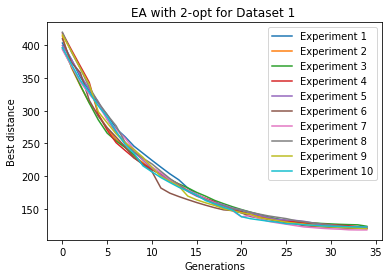

In [ ]:
start = time.time()

distancem, fitnessm, bestdism = evolutionaryAlgorithmWithTwoOpt(dataset1)

end = time.time()
execution_time = end-start

# Print information on the experiments
print('-----------------')
print(f'N_pool = {N_Pool},   N_cities = {len(dataset1)}')
print(f'N_Generations = {N_Generations},   N_Experiments = {N_Experiments}')
print(f'execution time = {int(execution_time)} seconds')
print(f'time per experiment = {execution_time/N_Experiments} seconds')

t = np.arange(0,N_Generations)
for i in range(N_Experiments):
    plt.plot(t, distancem[i], label=f'Experiment {i+1}')
    #plt.plot(t, bestdism[i], label=f'best for generation run {i+1}')
plt.title('EA with 2-opt for Dataset 1 ')
plt.xlabel('Generations')
plt.ylabel('Best distance') 
plt.legend()
plt.show()

N_Cities, 50
{1: array([ 0.2554, 18.2366]), 2: array([ 0.4339, 15.2476]), 3: array([0.7377, 8.3137]), 4: array([ 1.1354, 16.5638]), 5: array([ 1.582, 17.303]), 6: array([2.0913, 9.2924]), 7: array([ 2.2631, 17.3392]), 8: array([2.6373, 2.6425]), 9: array([ 3.004 , 19.5712]), 10: array([ 3.6684, 14.8018]), 11: array([ 3.863 , 13.7008]), 12: array([4.2065, 9.8224]), 13: array([4.8353, 2.0944]), 14: array([4.9785, 3.1596]), 15: array([ 5.3754, 17.6381]), 16: array([5.9425, 6.036 ]), 17: array([6.1451, 3.8132]), 18: array([ 6.7782, 11.0125]), 19: array([6.9223, 7.7819]), 20: array([7.5691, 0.9378]), 21: array([ 7.819 , 13.1697]), 22: array([8.3332, 5.9161]), 23: array([8.5872, 7.8303]), 24: array([ 9.1224, 14.5889]), 25: array([9.4076, 9.7166]), 26: array([9.7208, 8.1154]), 27: array([10.1662, 19.1705]), 28: array([10.7387,  2.009 ]), 29: array([10.9354,  5.1813]), 30: array([11.3707,  7.2406]), 31: array([11.7418, 13.6874]), 32: array([12.0526,  4.7186]), 33: array([12.6385, 12.1   ]), 34

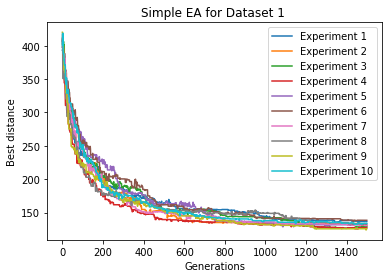

In [ ]:
start = time.time()

distance1, fitness1, bestdis1 = evolutionaryAlgorithm(dataset1)

end = time.time()
execution_time = end - start

# Print information on the experiments
print('-----------------')
print(f'N_pool = {N_Pool},   N_cities = {len(dataset1)}')
print(f'N_Generations = {N_Generations},   N_Experiments = {N_Experiments}')
print(f'execution time = {int(execution_time)} seconds')
print(f'time per experiment = {execution_time/N_Experiments} seconds')

t = np.arange(0,N_Generations)
for i in range(N_Experiments):
    plt.plot(t, distance1[i], label=f'Experiment {i+1}')
    #plt.plot(t, bestdis1[i], label=f'best for generation run {i+1}')
plt.title('Simple EA for Dataset 1 ')
plt.xlabel('Generations')
plt.ylabel('Best distance') 
plt.legend()
plt.show()

In [ ]:
# Initializing parameters of the simulations
N_Experiments = 10
N_Generations = 35
N_Pool = 500
# Simulations for the second dataset

# Read from the txt file the city coordinates and store them into a np array
dataset2 = np.loadtxt("bays29.tsp", usecols=(1,2))

N_Cities, 29
{1: array([1150., 1760.]), 2: array([ 630., 1660.]), 3: array([  40., 2090.]), 4: array([ 750., 1100.]), 5: array([ 750., 2030.]), 6: array([1030., 2070.]), 7: array([1650.,  650.]), 8: array([1490., 1630.]), 9: array([ 790., 2260.]), 10: array([ 710., 1310.]), 11: array([840., 550.]), 12: array([1170., 2300.]), 13: array([ 970., 1340.]), 14: array([510., 700.]), 15: array([750., 900.]), 16: array([1280., 1200.]), 17: array([230., 590.]), 18: array([460., 860.]), 19: array([1040.,  950.]), 20: array([ 590., 1390.]), 21: array([ 830., 1770.]), 22: array([490., 500.]), 23: array([1840., 1240.]), 24: array([1260., 1500.]), 25: array([1280.,  790.]), 26: array([ 490., 2130.]), 27: array([1460., 1420.]), 28: array([1260., 1910.]), 29: array([ 360., 1980.])}
End of Experiment 1: Distance value 8779.619954184907
End of Experiment 2: Distance value 8593.423826416216
End of Experiment 3: Distance value 8436.866819602052
End of Experiment 4: Distance value 8528.449331557898
End of E

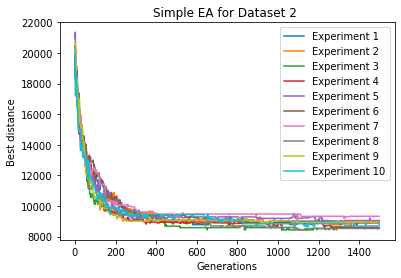

In [ ]:
start = time.time()

distance2, fitness2, bestdis2 = evolutionaryAlgorithm(dataset2)

end = time.time()
execution_time = end - start

# Print information on the experiments
print('-----------------')
print(f'N_pool = {N_Pool},   N_cities = {len(dataset2)}')
print(f'N_Generations = {N_Generations},   N_Experiments = {N_Experiments}')
print(f'execution time = {int(execution_time)} seconds')
print(f'time per experiment = {execution_time/N_Experiments} seconds')

t = np.arange(0,N_Generations)
for i in range(N_Experiments):
    plt.plot(t, distance2[i], label=f'Experiment {i+1}')
    #plt.plot(t, bestdis2[i], label=f'best for generation run {i+1}')
plt.title('Simple EA for Dataset 2 ')
plt.xlabel('Generations')
plt.ylabel('Best distance') 
plt.legend()
plt.show()

N_Cities, 29
{1: array([1150., 1760.]), 2: array([ 630., 1660.]), 3: array([  40., 2090.]), 4: array([ 750., 1100.]), 5: array([ 750., 2030.]), 6: array([1030., 2070.]), 7: array([1650.,  650.]), 8: array([1490., 1630.]), 9: array([ 790., 2260.]), 10: array([ 710., 1310.]), 11: array([840., 550.]), 12: array([1170., 2300.]), 13: array([ 970., 1340.]), 14: array([510., 700.]), 15: array([750., 900.]), 16: array([1280., 1200.]), 17: array([230., 590.]), 18: array([460., 860.]), 19: array([1040.,  950.]), 20: array([ 590., 1390.]), 21: array([ 830., 1770.]), 22: array([490., 500.]), 23: array([1840., 1240.]), 24: array([1260., 1500.]), 25: array([1280.,  790.]), 26: array([ 490., 2130.]), 27: array([1460., 1420.]), 28: array([1260., 1910.]), 29: array([ 360., 1980.])}
End of Experiment 1: Distance value 8624.273281482223
End of Experiment 2: Distance value 8224.407947524627
End of Experiment 3: Distance value 8282.502115077568
End of Experiment 4: Distance value 8373.757452021908
End of E

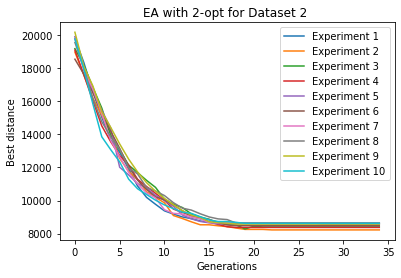

In [ ]:
start = time.time()

distance2m, fitness2m, bestdis2m = evolutionaryAlgorithmWithTwoOpt(dataset2)

end = time.time()
execution_time = end-start

# Print information on the experiments
print('-----------------')
print(f'N_pool = {N_Pool},   N_cities = {len(dataset2)}')
print(f'N_Generations = {N_Generations},   N_Experiments = {N_Experiments}')
print(f'execution time = {int(execution_time)} seconds')
print(f'time per experiment = {execution_time/N_Experiments} seconds')

t = np.arange(0,N_Generations)
for i in range(N_Experiments):
    plt.plot(t, distance2m[i], label=f'Experiment {i+1}')
    #plt.plot(t, bestdis2m[i], label=f'best for generation run {i+1}')
plt.title('EA with 2-opt for Dataset 2 ')
plt.xlabel('Generations')
plt.ylabel('Best distance') 
plt.legend()
plt.show()
